In [13]:
import os
os.chdir('C:\\Users\\Syed Hasnat\\OneDrive - Higher Education Commission\\HI Research\\pyimagesearch')
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from timeseires.utils.to_split import to_split
from timeseires.utils.multivariate_multi_step import multivariate_multi_step
from timeseires.utils.multivariate_single_step import multivariate_single_step
from timeseires.utils.univariate_multi_step import univariate_multi_step
from timeseires.utils.univariate_single_step import univariate_single_step
from timeseires.callbacks.TrainingMonitor import TrainingMonitor
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Bidirectional, GRU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D,TimeDistributed
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,MaxPooling1D,Concatenate,AveragePooling1D, GlobalMaxPooling1D, Input
from tensorflow.keras.models import Sequential,Model
import pandas as pd
import time, pickle
import pydot
import numpy as np
import tensorflow.keras.backend as K
import tensorflow as tf
import tensorflow
from tensorflow.keras.layers import Input, Reshape, Dense, Lambda, RepeatVector
from tensorflow.keras.layers import Layer, Flatten, LeakyReLU, concatenate
from tensorflow.keras.regularizers import l2
import glob

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\Syed Hasnat\\OneDrive - Higher Education Commission\\HI Research\\pyimagesearch'

In [14]:
class PC:
    @staticmethod
    def conv_module(x, num_filter, kr, stride ,padding="same", reg=0.0005, name=None):
        # initialize the CONV, BN, and RELU layer names
        (convName, bnName, actName) = (None, None, None)
        
        # if a layer name was supplied, prepend it
        if name is not None:
            convName = name + "_conv"
            bnName = name + "_bn"
            actName = name + "_act"
        # define a CONV => BN => RELU pattern
        x = Conv1D(num_filter, kr, strides=stride, padding=padding, kernel_regularizer=l2(reg),name=convName)(x)
        x = BatchNormalization(axis=-1, name=bnName)(x)
        x = Activation("selu", name=actName)(x)
        
        # return the block
        return x
    
    @staticmethod
    def inception_module(x, num1x1, num3x3Reduce, num3x3,num5x5Reduce, num5x5, stage, reg=0.0005):
        # define the first branch of the Inception module which
        # consists of 1x1 convolutions
        first = PC.conv_module(x, num1x1, 1, 1, reg=reg, name=stage + "_first")
        
        # define the second branch of the Inception module which
        # consists of 1x1 and 3x3 convolutions
        second = PC.conv_module(x, num3x3Reduce, 1, 1,  reg=reg, name=stage + "_second1")
        second = PC.conv_module(second, num3x3, 3, 1, reg=reg, name=stage + "_second2")
        
        # define the third branch of the Inception module which
        # are our 1x1 and 5x5 convolutions
        third = PC.conv_module(x, num5x5Reduce, 1, 1,  reg=reg, name=stage + "_third1")
        third = PC.conv_module(third, num5x5, 5, 1,  reg=reg, name=stage + "_third2")
        
        # concatenate across the channel dimension
        x = concatenate([first, second, third], axis=-1 ,name=stage + "_mixed")
        
        # return the block
        return x

In [7]:
#3.72
time_steps=24
num_features=22
def hybrid():
    inputs = Input(shape=(time_steps, num_features))
    lstm1, h, c = LSTM(48, return_sequences=True, return_state=True)(inputs)
    
    lstm2, h, c = LSTM(48, return_sequences=True, return_state=True)(lstm1)
    
    incp1 = PC.inception_module(lstm2, 32, 32, 64, 8, 32, "2a")    

    incp2 = PC.inception_module(incp1, 64, 64, 128, 16, 64, "3a")
    
    #.......................................................................

    flat = Flatten()(incp2)
    
    x = Activation('tanh')(flat)
    x=Dropout(0.2)(x)
    x = Dense(24, activation="sigmoid")(x)
    #.......................................................................
    model = Model(inputs, x)
    return model

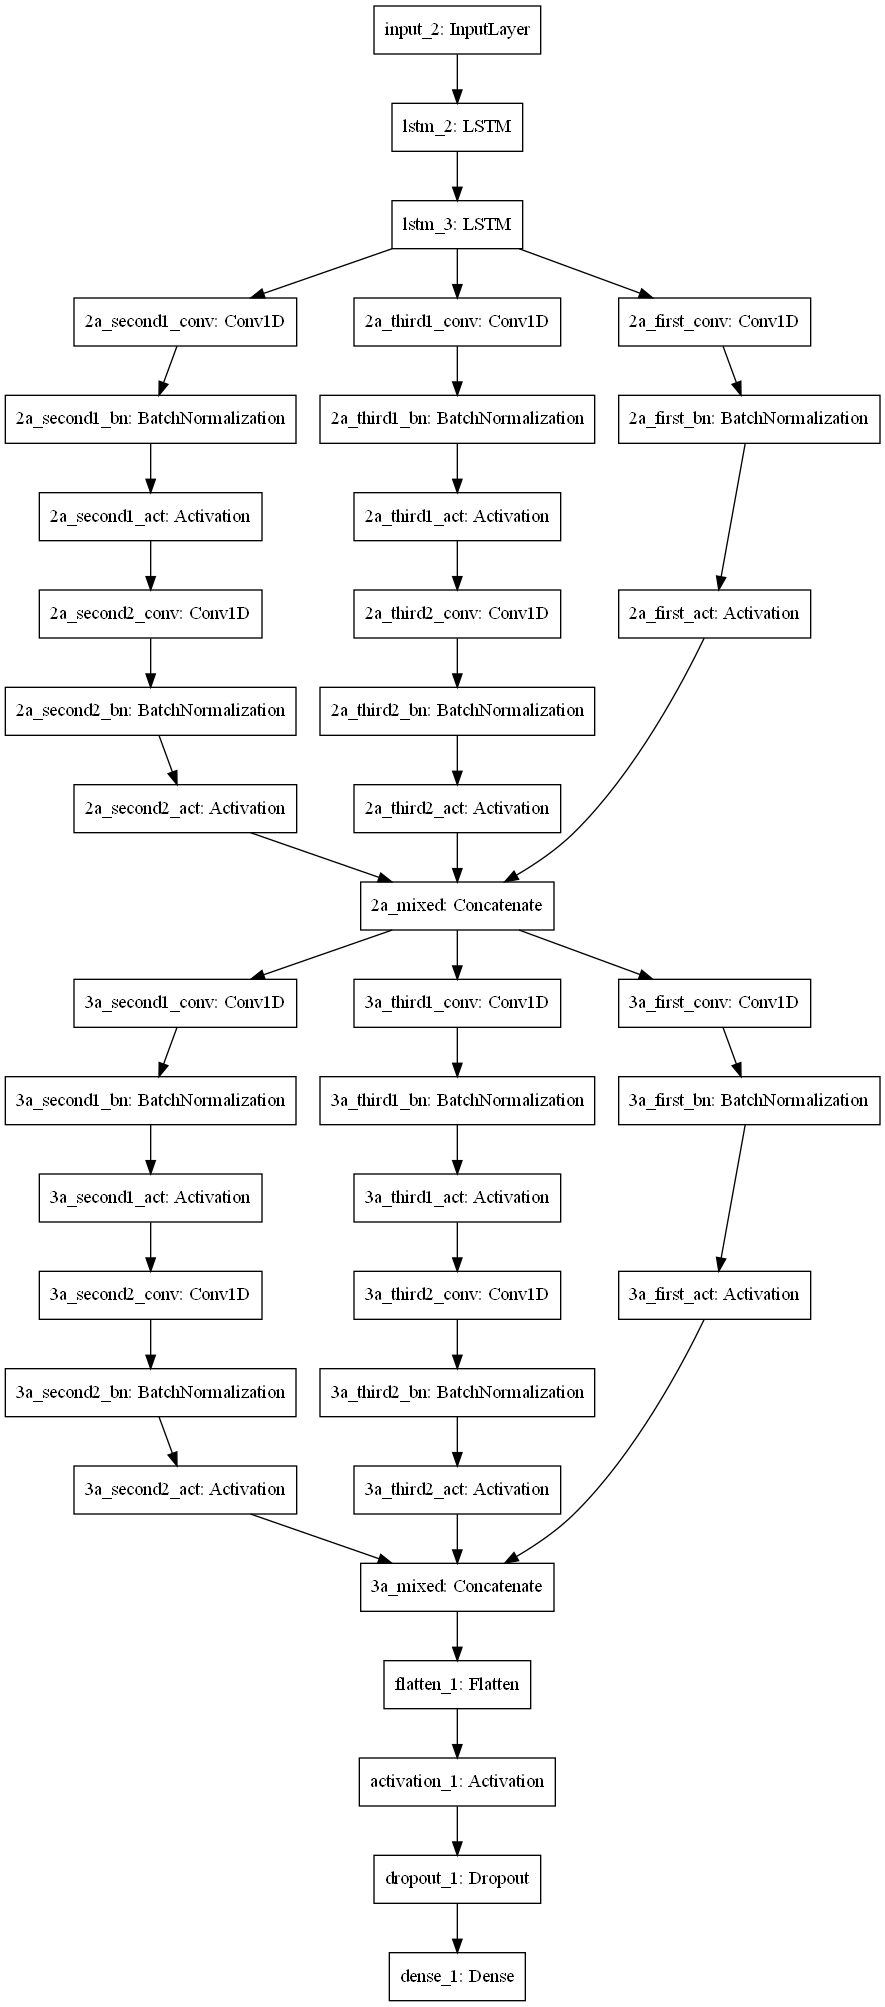

In [8]:
model = hybrid()
tensorflow.keras.utils.plot_model(model)

In [9]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 24, 22)]     0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 24, 48), (No 13632       input_2[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 24, 48), (No 18624       lstm_2[0][0]                     
__________________________________________________________________________________________________
2a_second1_conv (Conv1D)        (None, 24, 32)       1568        lstm_3[0][0]                     
_______________________________________________________________________________________

In [10]:
checkpoints = 'D:\\Checkpoints\\6_MDPI\\Multistep\\19_ISONE_proposed\\E1-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
OUTPUT_PATH = 'D:\\Checkpoints\\6_MDPI\\Multistep\\19_ISONE_proposed'
FIG_PATH = os.path.sep.join([OUTPUT_PATH,"history.png"])
JSON_PATH = os.path.sep.join([OUTPUT_PATH,"history.json"])

In [15]:
model = None
start_epoch = 0
time_steps=24
num_features=22

In [16]:
import os
path_dataset ='C:\\Users\\Syed Hasnat\\OneDrive - Higher Education Commission\\HI Research\\Datasets\\ISONE\\'
path_tr = os.path.join(path_dataset, 'ISONE_train.csv')
df_tr = pd.read_csv(path_tr)
train_set = df_tr.iloc[:].values
path_v = os.path.join(path_dataset, 'ISONE_validation.csv')
df_v = pd.read_csv(path_v)
validation_set = df_v.iloc[:].values 
path_te = os.path.join(path_dataset, 'ISONE_test.csv')
df_te = pd.read_csv(path_te)
test_set = df_te.iloc[:].values 

path_te = os.path.join(path_dataset, 'ISONE_testN1.csv')
df_te = pd.read_csv(path_te)
test_set1 = df_te.iloc[:].values 

path_te = os.path.join(path_dataset, 'ISONE_testN2.csv')
df_te = pd.read_csv(path_te)
test_set2 = df_te.iloc[:].values 

path_te = os.path.join(path_dataset, 'ISONE_testN3.csv')
df_te = pd.read_csv(path_te)
test_set3 = df_te.iloc[:].values 

path_scaler = os.path.join(path_dataset, 'ISONE_scaler.pkl')
scaler         = pickle.load(open(path_scaler, 'rb'))

train_set.shape, validation_set.shape, test_set.shape

((67502, 22), (19286, 22), (9644, 22))

In [19]:
time_steps=24
start = time.time()
train_X , train_y = univariate_multi_step(train_set, time_steps, target_col=0,target_len=24)
validation_X, validation_y = univariate_multi_step(validation_set, time_steps, target_col=0,target_len=24)
test_X, test_y = univariate_multi_step(test_set, time_steps, target_col=0,target_len=24)
test_X1, test_y1 = univariate_multi_step(test_set1, time_steps, target_col=0,target_len=24)
test_X2, test_y2 = univariate_multi_step(test_set2, time_steps, target_col=0,target_len=24)
test_X3, test_y3 = univariate_multi_step(test_set3, time_steps, target_col=0,target_len=24)
print('Time Consumed', time.time()-start, "sec")

Time Consumed 0.8606188297271729 sec


In [15]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model = hybrid()
    opt = Adam(1e-3)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] compiling model...


In [16]:
epochs = 30
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   #pa batch 16 mape 7.72%
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                        verbose = verbose)


Epoch 1/30
2105/2108 [============================>.] - ETA: 0s - loss: 0.0997 - mae: 0.0596 - mape: 2244.4900
Epoch 00001: val_loss improved from inf to 0.04143, saving model to D:\Checkpoints\6_MDPI\Multistep\19_ISONE_proposed\E1-cp-0001-loss0.04.h5
2108/2108 [==============================] - 36s 17ms/step - loss: 0.0996 - mae: 0.0596 - mape: 2241.3806 - val_loss: 0.0414 - val_mae: 0.0369 - val_mape: 16.4527
Epoch 2/30
2106/2108 [============================>.] - ETA: 0s - loss: 0.0392 - mae: 0.0356 - mape: 1915.7120
Epoch 00002: val_loss improved from 0.04143 to 0.03440, saving model to D:\Checkpoints\6_MDPI\Multistep\19_ISONE_proposed\E1-cp-0002-loss0.03.h5
2108/2108 [==============================] - 36s 17ms/step - loss: 0.0392 - mae: 0.0356 - mape: 1913.9606 - val_loss: 0.0344 - val_mae: 0.0320 - val_mape: 13.6742
Epoch 3/30
2107/2108 [============================>.] - ETA: 0s - loss: 0.0323 - mae: 0.0301 - mape: 1856.3053
Epoch 00003: val_loss did not improve from 0.03440
2108

In [22]:
model = load_model('D:\\Checkpoints\\6_MDPI\\Multistep\\19_ISONE_proposed\\E1-cp-0016-loss0.02.h5')
scaler = pickle.load(open("C:\\Users\\arif\\OneDrive - Higher Education Commission\\HI Research\\Datasets\\ISONE\\ISONE_scaler.pkl", 'rb'))
y_pred_scaled   = model.predict(test_X) 
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled))
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

Mean Absolute Error (MAE): 422.87
Median Absolute Error (MedAE): 295.43
Mean Squared Error (MSE): 399539.9
Root Mean Squared Error (RMSE): 632.09
Mean Absolute Percentage Error (MAPE): 2.88 %
Median Absolute Percentage Error (MDAPE): 2.13 %


y_test_unscaled.shape=  (9596, 24)
y_pred.shape=  (9596, 24)


# Tunining

In [23]:
checkpoints = 'D:\\Checkpoints\\6_MDPI\\Multistep\\19_ISONE_proposed\\E2-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
model='D:\\Checkpoints\\6_MDPI\\Multistep\\19_ISONE_proposed\\E1-cp-0016-loss0.02.h5'
start_epoch= 17

In [24]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model = PC.build(time_steps=24, num_features=17, reg=0.0005)
    opt = Adam(1e-3)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] loading D:\Checkpoints\6_MDPI\Multistep\19_ISONE_proposed\E1-cp-0016-loss0.02.h5...
[INFO] old learning rate: 0.0010000000474974513
[INFO] new learning rate: 9.999999747378752e-05


In [25]:
epochs = 30
verbose = 1 #0
batch_size = 256
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                        verbose = verbose)

Epoch 1/30
264/264 [==============================] - ETA: 0s - loss: 0.0196 - mean_absolute_error: 0.0191 - mean_absolute_percentage_error: 1561.6154
Epoch 00001: val_loss improved from inf to 0.02122, saving model to D:\Checkpoints\6_MDPI\Multistep\19_ISONE_proposed\E2-cp-0001-loss0.02.h5
264/264 [==============================] - 29s 108ms/step - loss: 0.0196 - mean_absolute_error: 0.0191 - mean_absolute_percentage_error: 1561.6154 - val_loss: 0.0212 - val_mean_absolute_error: 0.0206 - val_mean_absolute_percentage_error: 8.0730
Epoch 2/30
264/264 [==============================] - ETA: 0s - loss: 0.0193 - mean_absolute_error: 0.0187 - mean_absolute_percentage_error: 1576.2383  ETA: 13s - loss: 
Epoch 00002: val_loss did not improve from 0.02122
264/264 [==============================] - 28s 105ms/step - loss: 0.0193 - mean_absolute_error: 0.0187 - mean_absolute_percentage_error: 1576.2383 - val_loss: 0.0214 - val_mean_absolute_error: 0.0208 - val_mean_absolute_percentage_error: 8.19

In [28]:
model = load_model('D:\\Checkpoints\\6_MDPI\\Multistep\\19_ISONE_proposed\\E2-cp-0030-loss0.02.h5')
scaler = pickle.load(open("C:\\Users\\arif\\OneDrive - Higher Education Commission\\HI Research\\Datasets\\ISONE\\ISONE_scaler.pkl", 'rb'))
y_pred_scaled   = model.predict(test_X) 
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled))
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

Mean Absolute Error (MAE): 400.67
Median Absolute Error (MedAE): 261.18
Mean Squared Error (MSE): 399335.78
Root Mean Squared Error (RMSE): 631.93
Mean Absolute Percentage Error (MAPE): 2.7 %
Median Absolute Percentage Error (MDAPE): 1.87 %


y_test_unscaled.shape=  (9596, 24)
y_pred.shape=  (9596, 24)


# 1 std Noise

In [21]:
model = load_model('C:\\Users\\Syed Hasnat\\OneDrive - Higher Education Commission\\HI Research\\6_MDPI GoogLeNet Series\\Check points\\Multistep\\19_ISONE_proposed\\E2-cp-0030-loss0.02.h5')
# scaler = pickle.load(open("C:\\Users\\arif\\OneDrive - Higher Education Commission\\HI Research\\Datasets\\ISONE\\ISONE_scaler.pkl", 'rb'))
y_pred_scaled   = model.predict(test_X1) 
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y1)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled))
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

300/300 [==============================] - 6s 15ms/step
Mean Absolute Error (MAE): 404.35
Median Absolute Error (MedAE): 265.19
Mean Squared Error (MSE): 403182.07
Root Mean Squared Error (RMSE): 634.97
Mean Absolute Percentage Error (MAPE): 2.73 %
Median Absolute Percentage Error (MDAPE): 1.9 %


y_test_unscaled.shape=  (9596, 24)
y_pred.shape=  (9596, 24)


# 2 std

In [22]:
model = load_model('C:\\Users\\Syed Hasnat\\OneDrive - Higher Education Commission\\HI Research\\6_MDPI GoogLeNet Series\\Check points\\Multistep\\19_ISONE_proposed\\E2-cp-0030-loss0.02.h5')
# scaler = pickle.load(open("C:\\Users\\arif\\OneDrive - Higher Education Commission\\HI Research\\Datasets\\ISONE\\ISONE_scaler.pkl", 'rb'))
y_pred_scaled   = model.predict(test_X2) 
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y2)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled))
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

300/300 [==============================] - 6s 15ms/step
Mean Absolute Error (MAE): 415.37
Median Absolute Error (MedAE): 275.37
Mean Squared Error (MSE): 416266.93
Root Mean Squared Error (RMSE): 645.19
Mean Absolute Percentage Error (MAPE): 2.8 %
Median Absolute Percentage Error (MDAPE): 1.97 %


y_test_unscaled.shape=  (9596, 24)
y_pred.shape=  (9596, 24)


# 3 std

In [23]:
model = load_model('C:\\Users\\Syed Hasnat\\OneDrive - Higher Education Commission\\HI Research\\6_MDPI GoogLeNet Series\\Check points\\Multistep\\19_ISONE_proposed\\E2-cp-0030-loss0.02.h5')
# scaler = pickle.load(open("C:\\Users\\arif\\OneDrive - Higher Education Commission\\HI Research\\Datasets\\ISONE\\ISONE_scaler.pkl", 'rb'))
y_pred_scaled   = model.predict(test_X3) 
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y3)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled))
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

300/300 [==============================] - 6s 14ms/step
Mean Absolute Error (MAE): 432.35
Median Absolute Error (MedAE): 289.67
Mean Squared Error (MSE): 438521.42
Root Mean Squared Error (RMSE): 662.21
Mean Absolute Percentage Error (MAPE): 2.91 %
Median Absolute Percentage Error (MDAPE): 2.07 %


y_test_unscaled.shape=  (9596, 24)
y_pred.shape=  (9596, 24)


# Tune 2

In [33]:
checkpoints = 'D:\\Checkpoints\\6_MDPI\\Multistep\\13\\E3-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
model='D:\\Checkpoints\\6_MDPI\\Multistep\\13\\E2-cp-0024-loss0.03.h5'
start_epoch= 15+24

In [34]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model = PC.build(time_steps=24, num_features=17, reg=0.0005)
    opt = Adam(1e-3)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-5)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] loading D:\Checkpoints\6_MDPI\Multistep\13\E2-cp-0024-loss0.03.h5...
[INFO] old learning rate: 9.999999747378752e-05
[INFO] new learning rate: 9.999999747378752e-06


In [35]:
epochs = 20
verbose = 1 #0
batch_size = 1024
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                        verbose = verbose)

Epoch 1/20
32/32 [==============================] - ETA: 0s - loss: 0.0231 - mean_absolute_error: 0.0229 - mean_absolute_percentage_error: 9068.5088
Epoch 00001: val_loss improved from inf to 0.02759, saving model to D:\Checkpoints\6_MDPI\Multistep\13\E3-cp-0001-loss0.03.h5
32/32 [==============================] - 17s 534ms/step - loss: 0.0231 - mean_absolute_error: 0.0229 - mean_absolute_percentage_error: 9068.5088 - val_loss: 0.0276 - val_mean_absolute_error: 0.0274 - val_mean_absolute_percentage_error: 4.7865
Epoch 2/20
32/32 [==============================] - ETA: 0s - loss: 0.0231 - mean_absolute_error: 0.0229 - mean_absolute_percentage_error: 9177.2305
Epoch 00002: val_loss did not improve from 0.02759
32/32 [==============================] - 16s 492ms/step - loss: 0.0231 - mean_absolute_error: 0.0229 - mean_absolute_percentage_error: 9177.2305 - val_loss: 0.0276 - val_mean_absolute_error: 0.0274 - val_mean_absolute_percentage_error: 4.7897
Epoch 3/20
32/32 [=====================

In [36]:
model = load_model('D:\\Checkpoints\\6_MDPI\\Multistep\\14\\E1-cp-0019-loss0.03.h5')
scaler = pickle.load(open("C:\\Users\\arif\\OneDrive - Higher Education Commission\\HI Research\\Datasets\\AEP\\AEP_scaler.pkl", 'rb'))
y_pred_scaled   = model.predict(test_X) 
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled))
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

Mean Absolute Error (MAE): 370.91
Median Absolute Error (MedAE): 288.05
Mean Squared Error (MSE): 250523.34
Root Mean Squared Error (RMSE): 500.52
Mean Absolute Percentage Error (MAPE): 3.72 %
Median Absolute Percentage Error (MDAPE): 2.8 %


y_test_unscaled.shape=  (4624, 24)
y_pred.shape=  (4624, 24)
